In [1]:
import numpy as np
import pandas as pd
import pandana as pdna
import geopandas as gp
import matplotlib.pyplot as plt
%matplotlib inline
# import folium

In [2]:
homedata_file_path = '/home/data/'
dd = '/home/data/spring_2019/base/'
shapefiles_path = '/home/simon/spatial-data/'
model_outputs_path = '/home/data/spring_2019/outputs/'

In [3]:
store = pd.HDFStore(model_outputs_path+'model_data_output.h5') #sometimes doesnt work with a relative file path


Opening /home/data/spring_2019/outputs/model_data_output.h5 in read-only mode


In [4]:
#load in everything
households_2025 = store['/2025/households']
households_2015 = store['/2015/households']
households_2010 = store['/2010/households']

parcels_2025 = store['/2025/parcels']
parcels_2015 = store['/2015/parcels']
parcels_2010 = store['/2010/parcels']

persons_2025 = store['/2025/persons']
persons_2015 = store['/2015/persons']
persons_2010 = store['/2010/persons']

jobs_2025 = store['/2025/jobs']
jobs_2015 = store['/2015/jobs']
jobs_2010 = store['/2010/jobs']

buildings_2025 = store['/2025/buildings']
buildings_2015 = store['/2015/buildings']
buildings_2010 = store['/2010/buildings']

#ascii issue
# establishments_2025 = store['/2025/establishments']
# establishments_2015 = store['/2015/establishments']
# establishments_2010 = store['/2010/establishments']


In [5]:
# persons_subset_25 = persons_2025.head(100000)
# jobs_subset_25 = jobs_2025.head(100000)

In [6]:
def compare(table, column):
    return len(table[column].unique())

2025

In [7]:
per_house_2025 = pd.merge(persons_2025, households_2025, left_on='household_id', right_index=True, how='inner') #97139 inner merge, 100000 left merge, 15843 unique building ids in this subset


In [8]:
house_build_2025 = pd.merge(per_house_2025, buildings_2025, left_on='building_id', right_index=True, how='inner') #just the households with assigned buildings and the buildings with assigned households?


In [9]:
build_parcel_2025 = pd.merge(house_build_2025, parcels_2025, left_on='parcel_id',right_index=True, how='inner')
build_parcel_2025.head()

,student,household_id,age,primary_commute_mode,worker,work_at_home,sex,hours,hispanic,race_id,...,shape_area,apn,tax_exempt_status,county_id,y,x,land_value,imputation_flag,zone_id,node_id
1,0,670,47,1.0,1,0,1,40.0,1,1,...,1546.620624,25929029,0,85,37.334387,-121.90115,516270.465,"_, cs_nrsqft, du_zonetarget",539,294507
4804,0,694,29,11.0,1,1,1,5.0,1,1,...,1546.620624,25929029,0,85,37.334387,-121.90115,516270.465,"_, cs_nrsqft, du_zonetarget",539,294507
42635,0,734,61,NaN,0,0,1,NaN,1,1,...,1546.620624,25929029,0,85,37.334387,-121.90115,516270.465,"_, cs_nrsqft, du_zonetarget",539,294507
47730,1,777,43,1.0,1,0,2,38.0,1,1,...,1546.620624,25929029,0,85,37.334387,-121.90115,516270.465,"_, cs_nrsqft, du_zonetarget",539,294507
47731,1,777,49,11.0,1,1,1,15.0,1,1,...,1546.620624,25929029,0,85,37.334387,-121.90115,516270.465,"_, cs_nrsqft, du_zonetarget",539,294507


2015

In [10]:
# per_house_2015 = pd.merge(persons_2015, households_2015, on='household_id', how='inner') #97139 inner merge, 100000 left merge, 15843 unique building ids in this subset



In [11]:
# house_build_2015 = pd.merge(per_house_2015, build 0ings, on='building_id', how='inner') #just the households with assigned buildings and the buildings with assigned households?


In [12]:
# build_parcel_2015 = pd.merge(house_build, parcels, left_on='parcel_id',right_on='primary_id', how='inner')


2010

In [13]:
# per_house_2010 = pd.merge(persons_2010, households_2010, on='household_id', how='inner') #97139 inner merge, 100000 left merge, 15843 unique building ids in this subset


In [14]:
# house_build_2010 = pd.merge(per_house_2010, build 0ings, on='building_id', how='inner') #just the households with assigned buildings and the buildings with assigned households?


In [15]:
# build_parcel_2010 = pd.merge(house_build, parcels, left_on='parcel_id',right_on='primary_id', how='inner')


Get the number of workers for each race by node

In [16]:
def workers_by_race(df):
    nhwhite_workers = sum((df["race_id"] == 1) & (df["hispanic"] == 1) & (df["worker"] == 1))
    nhblack_workers = sum((df["race_id"] == 2) & (df["hispanic"] == 1) & (df["worker"] == 1))
    nhasian_workers = sum((df["race_id"] == 6) & (df["hispanic"] == 1) & (df["worker"] == 1))
    hispanic_workers = sum((df["hispanic"] != 1) & (df["worker"] == 1))
    non_workers_any = sum(df["worker"] == 0)
    block = df['block_id'].iloc[0] # i think this is ok for now because they should all be the same
    return [nhwhite_workers, nhblack_workers, nhasian_workers, hispanic_workers, non_workers_any, block]

In [18]:
node_df_lol = []
node_id_list = []
for node_id, node_df in build_parcel_2025.groupby("node_id"):
    node_id_list.append(node_id)
    row = []
    row.extend(workers_by_race(node_df))
    node_df_lol.append(row)
workers_by_node = pd.DataFrame(node_df_lol, columns=["nhwhite_workers", "nhblack_workers","nhasian_workers",
              "hispanic_workers", "non_workers_any", "block_id"], index=node_id_list)


In [19]:
len(workers_by_node)

168000

In [20]:
block_groups = gp.read_file(shapefiles_path+'tl_2018_06_bg/tl_2018_06_bg.shp')
# tracts = gp.read_file(shapefiles_path+'tl_2018_06_tract/tl_2018_06_tract.shp')


Pandana Accessibility Calcs

In [21]:
beam_network_links = pd.read_csv('beam-network-links.csv')
beam_network_nodes = pd.read_csv('beam-network-nodes.csv')

In [22]:
net=pdna.Network(beam_network_nodes.x, beam_network_nodes.y, beam_network_links["from"], beam_network_links["to"],
                 beam_network_links[["travelTime"]])
net.precompute(3000)



/home/amelia/enter/envs/template-env/lib/python3.6/site-packages/pandana/network.py:132: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.as_matrix().astype('float32'),
/home/amelia/enter/envs/template-env/lib/python3.6/site-packages/pandana/network.py:133: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix().astype('int32'),
/home/amelia/enter/envs/template-env/lib/python3.6/site-packages/pandana/network.py:134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges_df[edge_weights.columns].transpose()


In [23]:
jobs_buildings_2025 = pd.merge(jobs_2025, buildings_2025, left_on='building_id', right_index=True)


In [24]:
jobs_buildings_parcels_2025 = pd.merge(jobs_buildings_2025, parcels_2025, left_on='parcel_id', right_index=True)


In [25]:
# jobs_x, jobs_y = jobs_buildings_parcels_2025['lon'], jobs_buildings_parcels_2025['lat']
node_ids = jobs_buildings_parcels_2025["node_id"]
n = net.set(node_ids)


Removed 3323306 rows because they contain missing values


In [26]:
%time s = net.aggregate(10000, type="sum", decay="linear")


CPU times: user 28min 38s, sys: 4.01 s, total: 28min 42s
Wall time: 1min 12s


In [27]:
jobs_access_100000 = pd.DataFrame(s)

In [28]:
test_merge = pd.merge(workers_by_node, jobs_access_100000, right_index=True, left_index=True)
test_merge = test_merge.rename({0:"jobs"}, inplace=False, axis=1)
test_merge["blk_group"] = test_merge["block_id"].apply(lambda x: x[:-3])#get just the block group


In [29]:
def accessibilities_by_race(df, people_per_blk_gp):
    
    node_person_total = df["nhwhite_workers"] + df["nhblack_workers"]+df["nhasian_workers"]+df["hispanic_workers"]
    node_access_nhw = sum(df["nhwhite_workers"]*df["jobs"])/people_per_blk_gp
    node_access_nhb = sum(df["nhblack_workers"]*df["jobs"])/people_per_blk_gp
    node_access_nha = sum(df["nhasian_workers"]*df["jobs"])/people_per_blk_gp
    node_access_hw = sum(df["hispanic_workers"]*df["jobs"])/people_per_blk_gp
    return [node_access_nhw, node_access_nhb, node_access_nha, node_access_hw]



In [30]:
blk_df_lol = []
blk_id_list = []
for blk_id, blk_df in test_merge.groupby("blk_group"):
    blk_id_list.append(blk_id)
    people_per_blk_gp = sum(blk_df["nhwhite_workers"] + blk_df["nhblack_workers"]+blk_df["nhasian_workers"]+blk_df["hispanic_workers"])+1e-6
    row = accessibilities_by_race(blk_df, people_per_blk_gp)
    blk_df_lol.append(row)
access_blk = pd.DataFrame(blk_df_lol, columns=["access_nhwhite", "access_nhblack","access_nhasian",
              "access_hispanic"], index=blk_id_list)


In [31]:
block_access_shp = pd.merge(block_groups, access_blk, left_on='GEOID', right_index=True)


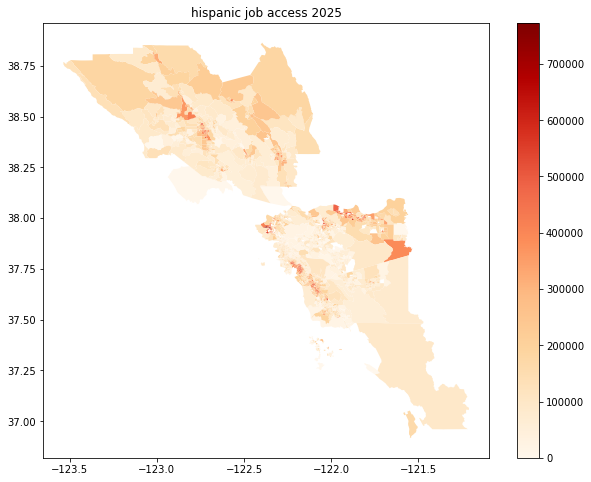

In [53]:
f, hisp_25 = plt.subplots(1, figsize=(10,8))
hisp_25 = block_access_shp.plot(axes=hisp_25, column='access_hispanic', legend = True, cmap='OrRd')
hisp_25.set_title("hispanic job access 2025")
plt.savefig("bg_his_jobs_10000m_2025")

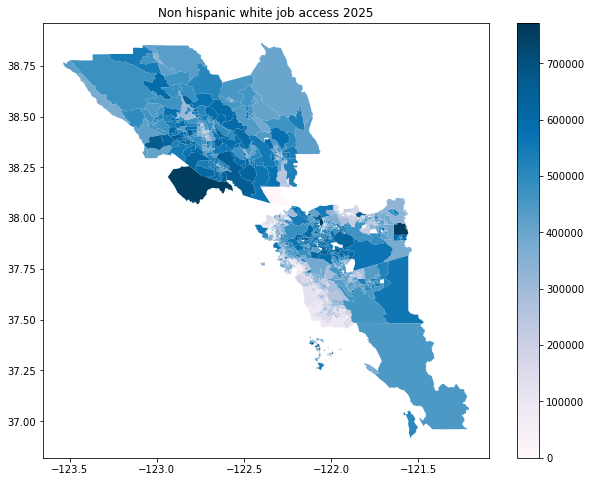

In [54]:
f, nhw_25 = plt.subplots(1, figsize=(10,8))
nhw_25 = block_access_shp.plot(axes=nhw_25, column='access_nhwhite', legend = True, cmap='PuBu')
nhw_25.set_title("Non hispanic white job access 2025")
plt.savefig("bg_nhw_jobs_10000m_2025")



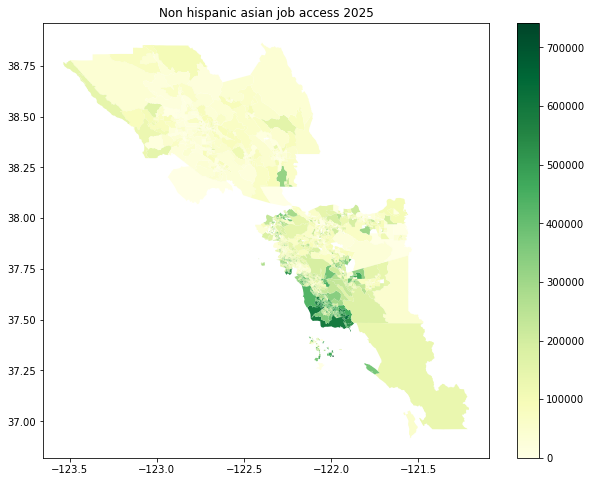

In [55]:
f, nha_25 = plt.subplots(1, figsize=(10,8))
nha_25 = block_access_shp.plot(axes=nha_25, column='access_nhasian', legend = True, cmap='YlGn')
nha_25.set_title("Non hispanic asian job access 2025")
plt.savefig("bg_nha_jobs_10000m_2025")



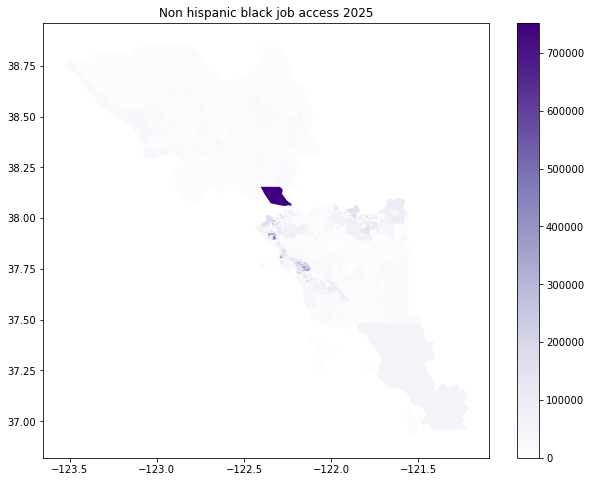

In [58]:
f, nhb_25 = plt.subplots(1, figsize=(10,8))
nhb_25 = block_access_shp.plot(ax = nhb_25, column='access_nhblack', legend = True, cmap='Purples')
nhb_25.set_title("Non hispanic black job access 2025")
plt.savefig("bg_nhb_jobs_10000m_2025")



In [60]:
accessibilities_by_race = access_blk.to_csv('access_blk.csv')